## CNN 스팸 메일 분류

### 데이터 로드 및 전처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<ipython-input-3-4cc5b33a9de7>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


* https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

In [ ]:
import urllib.request

urllib.request.urlretrieve('https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv',filename='spam.csv')
data=pd.read_csv("spam.csv",encoding='latin-1')
data


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

In [ ]:
# 원핫인코딩
data['v1']=data['v1'].replace(['ham','spam'], [0,1])

In [ ]:
# 중복제거
data.drop_duplicates(subset=['v2'],inplace=True)

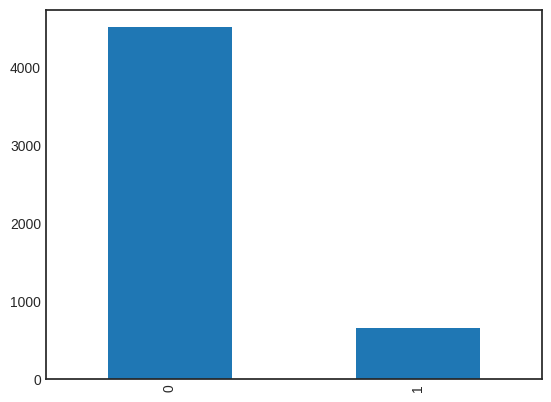

In [ ]:
# 0이 너무 많음
data['v1'].value_counts().plot(kind='bar');

In [ ]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


In [ ]:
x_data=data['v2']
y_data=data['v1']

In [ ]:
vocab_size=1000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_data)
sequences=tokenizer.texts_to_sequences(x_data)

In [ ]:
sequences[:5]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6],
 [53,
  537,
  8,
  20,
  4,
  934,
  2,
  220,
  706,
  267,
  70,
  2,
  2,
  359,
  537,
  604,
  82,
  436,
  185,
  707,
  437],
 [6, 226, 152, 23, 347, 6, 138, 145, 56, 152],
 [935, 1, 97, 96, 69, 453, 2, 877, 69, 198, 105, 438]]

In [ ]:
x_data=sequences

print('메일 최대 길이:{}'.format(max(len(l) for l in x_data)))
print('메일 평균 길이:{}'.format(sum(map(len, x_data))/len(x_data)))

메일 최대 길이:172
메일 평균 길이:12.566840781582512


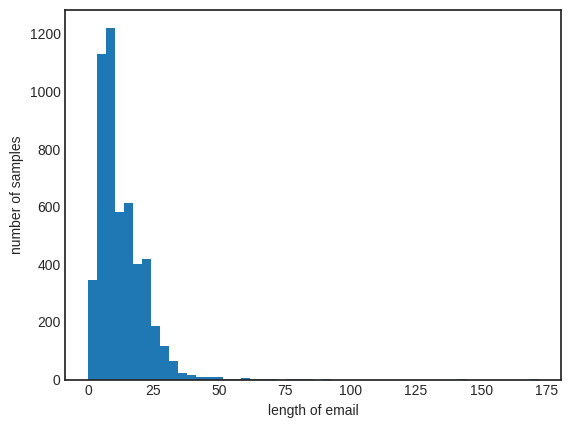

In [ ]:
plt.hist([len(s) for s in x_data], bins=50)
plt.xlabel('length of email')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len=60
data=pad_sequences(x_data, maxlen=max_len)
print(data.shape)

(5169, 60)


In [ ]:
n_train=int(len(sequences)*0.8)
n_test=int(len(sequences)-n_train)

print(n_train)
print(n_test)

4135
1034


In [ ]:
x_train=data[:n_train]
y_train=np.array(y_data[:n_train])
x_test=data[n_train:]
y_test=np.array(y_data[n_train:])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


### 모델 구성

In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model=Sequential() # 레이어를 선형으로 쌓아 구성하는 방식
model.add(Embedding(vocab_size,32)) # 첫 번째 레이어로 Embedding 추가. 단어 인덱스 벡터로 변환
model.add(Dropout(0.2)) # Dropout 레이어 추가. 학습과정에서 임의의 유닛 제외하여 과적합 방지
model.add(Conv1D(32, 5, strides=1, padding='valid',activation='relu')) # 1차원 합성곱(Conv1D) 레이어 추가
model.add(GlobalMaxPooling1D()) # 각 필터에서 가장 큰 값을 추출하여 공간적인 정보 요약
model.add(Dense(64,activation='relu')) # 64개의 뉴런 가짐. 활성화 함수 ReLU
model.add(Dropout(0.2)) # 20% 유닛 제외
model.add(Dense(1, activation='sigmoid')) # 출력 뉴런 1개, 활성화 함수 시그모이드 사용하여 이진 분류 문제에 적용
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
es= EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=3) # 모델의 성능이 향상되지 않을 때 학습을 조기에 종료시키는 역할
mc=ModelCheckpoint('best_model.h5',monitor='val_acc',mode='max', verbose=1, save_best_only=True) # 학습 중에 모델의 최상의 성능을 보이는 가중치를 저장

### 모델 학습

In [ ]:
history=model.fit(x_train, y_train,
                  epochs=10,
                  batch_size=64,
                  validation_split=0.2,
                  callbacks=[es,mc])

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.4601 - acc: 0.8691
Epoch 1: val_acc improved from -inf to 0.87304, saving model to best_model.h5
52/52 [==============================] - 14s 169ms/step - loss: 0.4601 - acc: 0.8691 - val_loss: 0.3876 - val_acc: 0.8730
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 0.3771 - acc: 0.8697
Epoch 2: val_acc did not improve from 0.87304
52/52 [==============================] - 6s 117ms/step - loss: 0.3771 - acc: 0.8697 - val_loss: 0.3571 - val_acc: 0.8730
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.2673 - acc: 0.8912
Epoch 3: val_acc improved from 0.87304 to 0.97582, saving model to best_model.h5
52/52 [==============================] - 3s 49ms/step - loss: 0.2673 - acc: 0.8912 - val_loss: 0.1372 - val_acc: 0.9758
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.0786 - acc: 0.9816
Epoch 4: val_acc improved from 0.97582 to 0.98549, saving model to best_model.h5
52/52 [==============================] - 2s 27ms/step - loss: 0.0786 - acc: 0.9816 - val_loss: 0.0514 - val_acc: 0.9855
Epoch 5/10
52/52 [==============================] - ETA: 0s - loss: 0.0417 - acc: 0.9894
Epoch 5: val_acc did not improve from 0.98549
52/52 [==============================] -

### 시각화

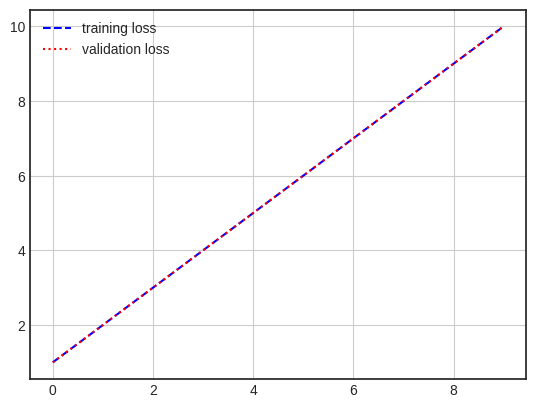

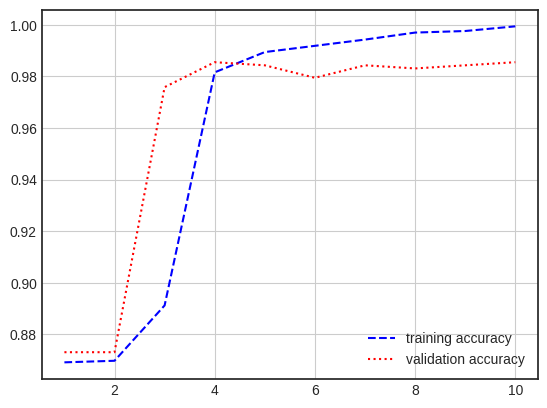

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['acc']
val_acc=history.history['val_acc']

epochs=range(1, len(loss)+1)

plt.plot(epochs, 'b--', label='training loss')
plt.plot(epochs, 'r:', label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc,'b--', label='training accuracy')
plt.plot(epochs,val_acc, 'r:', label='validation accuracy')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model.evaluate(x_test, y_test)

33/33 [==============================] - 0s 7ms/step - loss: 0.0607 - acc: 0.9787


[0.06066939979791641, 0.978723406791687]